In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_id(df, teamname):
    return df[df['country']==teamname]['country_id'].reset_index(drop=True)[0] 

In [3]:
def ret_victory_home(row):
    if row['goal1'] > row['goal2']:
        return 'победа'
    elif row['goal1'] < row['goal2']:
        return 'поражение'
    else:
        return 'ничья'
    
def ret_victory_guest(row):
    if row['goal1'] > row['goal2']:
        return 'поражение'
    elif row['goal1'] < row['goal2']:
        return 'победа'
    else:
        return 'ничья'

In [4]:
def get_home_game_points(row):
    if row['goal1'] > row['goal2']:
        return 3
    elif row['goal1'] < row['goal2']:
        return 0
    else:
        return 1

def get_guest_game_pints(row):
    if row['goal1'] > row['goal2']:
        return 0
    elif row['goal1'] < row['goal2']:
        return 3
    else:
        return 1

In [5]:
def get_group_table(df, group_name):   
    group_games = games_df[games_df['group'] == group_name]
    group_teams = pd.concat([group_games['team1'], group_games['team2']]).unique()
    group_table = []
    for team in group_teams:
        # Считаем таблицу "домашних" игр
        team_home_games = group_games[group_games['team1']==team]
        team_home_games['points'] = team_home_games.apply(get_home_game_points,axis=1)
        # Считаем таблицу "гостевых" игр
        team_guest_games = group_games[group_games['team2']==team]
        team_guest_games['points'] = team_guest_games.apply(get_guest_game_pints,axis=1)
        # Объединяем общую таблицу
        team_games= pd.concat([team_home_games, team_guest_games],axis=0)
        team_games['points'] = team_games['points'].astype('int')
        team_games_count = len(team_games)
        # Суммарные характеристики
        team_points = team_games['points'].sum()
        team_goals_scored = team_home_games['goal1'].sum() + team_guest_games['goal2'].sum()
        team_goals_missed = team_home_games['goal2'].sum() + team_guest_games['goal1'].sum()
        group_table.append([team, team_points, team_games_count, team_goals_scored, team_goals_missed])
    
    group_table = pd.DataFrame(group_table, columns=['team', 'points', 'games', 'goals_scored', 'goals_missed'])
    group_table['goals_diff'] = group_table['goals_scored'] - group_table['goals_missed']
    group_table = group_table.sort_values(by='points',ascending=False)
    try:
        group_table.index = [1, 2, 3, 4]
    except:
        group_table = group_table.reset_index(drop=True)
    return group_table

In [6]:
def get_lineup(lteam):
    lteam_id = get_id(countries, lteam)

    lplayers = players[players['country'] == lteam] # Общий состав страны
    lplayers_array = players['name']
    llineup = lineups_df[lineups_df['country_id']==lteam_id].pivot_table(index='name', values='total', aggfunc=['sum', 'count']) # Выходы
    llineup.columns = ['time', 'games']
    lteam_players = lplayers.merge(llineup, on='name', how='left')
    # Голы
    try:
        lgoals = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'].isin(['гол','пенальти']))]
         .pivot_table(index='name', values='event', aggfunc='count'))
        lgoals.columns = ['goals']
        lteam_players = lteam_players.merge(lgoals, on='name', how='left')
    except ValueError:
        lteam_players['goals'] = 0
    # Ассисты
    try:
        lassist = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'] == 'пас')]
         .pivot_table(index='name', values='event', aggfunc='count'))
        lassist.columns = ['assist']
        lteam_players = lteam_players.merge(lassist, on='name', how='left')
    except ValueError:
        lteam_players['assist'] = 0
    # Желтые карточки
    try:
        lyellows = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'] == 'желтая карточка')]
         .pivot_table(index='name', values='event', aggfunc='count'))
        lyellows.columns = ['yellows']
        lteam_players = lteam_players.merge(lyellows, on='name', how='left')
    except ValueError:
        lteam_players['yellows'] = 0
    # Красные карточки
    try:
        lreds = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'] == 'красная карточка')]
         .pivot_table(index='name', values='event', aggfunc='count'))
        lreds.columns = ['reds']
        lreds
        lteam_players = lteam_players.merge(lreds, on='name', how='left')
    except:
        lteam_players['reds'] = 0
    lteam_players = lteam_players.drop(['country_id', 'country'], axis=1)
    lteam_players = lteam_players.fillna(0)
    lteam_players[['age', 'time','games', 'goals', 'assist', 'yellows', 'reds']] = lteam_players[['age', 'time', 'games', 'goals', 'assist', 'yellows', 'reds']].astype('int')
    lteam_players.index = ['']*len(lteam_players) # Скрывает индекс
    return lteam_players.sort_values(by='num')

Загружаем таблицы

In [19]:
countries = pd.read_csv('countries.csv')
players = pd.read_csv('players.csv')
events_df = pd.read_csv('events.csv')
lineups_df = pd.read_csv('lineups.csv')
games_df = pd.read_csv('games.csv')
old_games = pd.read_csv('old_games.csv')

Правим таблицы

In [20]:
countries.columns = ['country_id', 'country']
players.columns = ['num', 'name', 'team', 'birthdate', 'pos', 'country_id']
lineups_df['total'] = lineups_df['out'] - lineups_df['in']
players = players.merge(countries, on='country_id')
players['birthdate'] = pd.to_datetime(players['birthdate'], format='%d-%m-%Y')
players['age'] = ((dt.datetime.now() - players['birthdate']).dt.days / 365).apply(np.floor)
old_games['date'] =  pd.to_datetime(old_games['date'], format='%d-%m-%Y')
games_df['group'] = games_df['group'].fillna('')

## Предварительная статистика

In [21]:
(players.
 pivot_table(index='team', values='num', aggfunc='count').
 sort_values(by='num', ascending=False).
 head(10)
)

,num
team,
Интер Милан,13
Манчестер Сити,13
Пари Сен-Жермен,12
Реал Мадрид,12
РБ Лейпциг,11
Барселона,11
Арсенал,10
Славия (Прага),10
Байер 04,10


### Возраст игроков

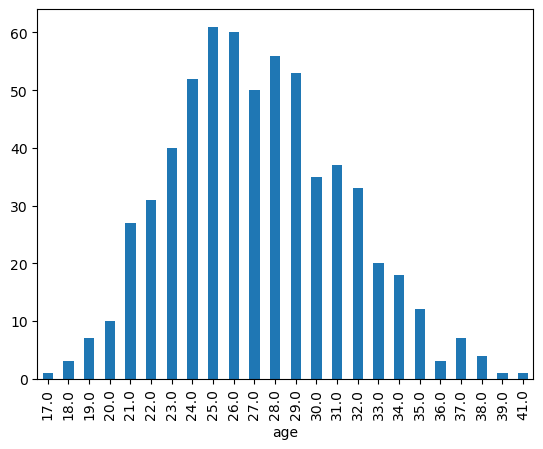

In [22]:
players.groupby('age')['num'].count().plot(kind='bar');

In [23]:
players['age'].describe()

count    622.000000
mean      27.178457
std        4.123143
min       17.000000
25%       24.000000
50%       27.000000
75%       30.000000
max       41.000000
Name: age, dtype: float64

Самые возрастные игроки

In [24]:
players.sort_values(by='birthdate').head(5)

,num,name,team,birthdate,pos,country_id,country,age
574,3,Пепе,Порту,1983-02-26,защ,23,Португалия,41.0
589,7,Криштиану Роналду,Ан-Наср (Эр-Рияд),1985-02-05,нап,23,Португалия,39.0
143,10,Лука Модрич,Реал Мадрид,1985-09-09,поз,6,Хорватия,38.0
113,22,Хесус Навас,Севилья,1985-11-21,защ,5,Испания,38.0
544,1,Георгий Лория,Динамо Тбилиси,1986-01-27,врт,22,Грузия,38.0


Самые молодые игроки

In [25]:
players.sort_values(by='birthdate', ascending=False).head(5)

,num,name,team,birthdate,pos,country_id,country,age
127,19,Ламин Ямаль,Барселона,2007-07-13,нап,5,Испания,17.0
405,18,Варрен Заир-Эмри,Пари Сен-Жермен,2006-03-08,поз,16,Франция,18.0
464,24,Лео Сауэр,Фейеноорд,2005-12-16,нап,18,Словакия,18.0
541,24,Семих Кылычсой,Бешикташ,2005-08-15,нап,21,Турция,18.0
561,26,Габриэль Сигуа,Базель,2005-06-30,поз,22,Грузия,19.0


Самые возрастные команды

In [26]:
players.pivot_table(index='country', values='age', aggfunc='mean').sort_values(by='age', ascending=False).head(5)

,age
country,
Германия,28.692308
Шотландия,28.423077
Польша,27.923077
Дания,27.884615
Швейцария,27.769231


Самые молодые команды

In [27]:
players.pivot_table(index='country', values='age', aggfunc='mean').sort_values(by='age').head(5)

,age
country,
Чехия,25.500000
Турция,25.923077
Англия,26.230769
Нидерланды,26.346154
Украина,26.384615


## Статистика турнира

### Турнирные таблицы

In [28]:
from string import ascii_uppercase as alc
for i in range(6):
    print('Группа ' + alc[i])
    display(get_group_table(games_df, alc[i]))

Группа A


,team,points,games,goals_scored,goals_missed,goals_diff
1,Германия,7,3,8,2,6
2,Швейцария,5,3,5,3,2
3,Венгрия,3,3,2,5,-3
4,Шотландия,1,3,2,7,-5


Группа B


,team,points,games,goals_scored,goals_missed,goals_diff
1,Испания,9,3,5,0,5
2,Италия,4,3,3,3,0
3,Хорватия,2,3,3,6,-3
4,Албания,1,3,3,5,-2


Группа C


,team,points,games,goals_scored,goals_missed,goals_diff
1,Англия,5,3,2,1,1
2,Словения,3,3,2,2,0
3,Дания,3,3,2,2,0
4,Сербия,2,3,1,2,-1


Группа D


,team,points,games,goals_scored,goals_missed,goals_diff
1,Австрия,6,3,6,4,2
2,Франция,5,3,2,1,1
3,Нидерланды,4,3,4,4,0
4,Польша,1,3,3,6,-3


Группа E


,team,points,games,goals_scored,goals_missed,goals_diff
1,Румыния,4,3,4,3,1
2,Бельгия,4,3,2,1,1
3,Словакия,4,3,3,3,0
4,Украина,4,3,2,4,-2


Группа F


,team,points,games,goals_scored,goals_missed,goals_diff
1,Турция,6,3,5,5,0
2,Португалия,6,3,5,3,2
3,Грузия,4,3,4,4,0
4,Чехия,1,3,3,5,-2


### Состав команды

In [29]:
get_lineup('Испания')

,num,name,team,birthdate,pos,age,time,games,goals,assist,yellows,reds
,1,Давид Райя,Арсенал,1995-09-15,врт,28,90,1,0,0,0,0
,2,Дани Карвахаль,Реал Мадрид,1992-01-11,защ,32,471,5,1,0,3,1
,3,Робен Ле Норман,Реал Сосьедад,1996-11-11,защ,27,443,6,0,0,2,0
,4,Начо Фернандес,Реал Мадрид,1990-01-18,защ,34,261,4,0,0,0,0
,5,Дани Вивиан,Атлетик Бильбао,1999-07-05,защ,25,122,2,0,0,1,0
,6,Микель Мерино,Реал Сосьедад,1996-06-22,поз,28,177,7,1,0,0,0
,7,Альваро Мората,Атлетико Мадрид,1992-10-23,нап,31,454,7,1,0,1,0
,8,Фабиан Руис,Пари Сен-Жермен,1996-04-03,поз,28,542,6,2,2,1,0
,9,Хоселу,Реал Мадрид,1990-05-27,нап,34,108,2,0,0,0,0
,10,Дани Ольмо,РБ Лейпциг,1998-05-07,нап,26,431,6,3,2,1,0


In [30]:
get_lineup('Англия')

,num,name,team,birthdate,pos,age,time,games,goals,assist,yellows,reds
,1,Джордан Пикфорд,Эвертон,1994-03-07,врт,30,690,7,0,0,0,0
,2,Кайл Уокер,Манчестер Сити,1990-05-28,защ,34,690,7,0,0,0,0
,3,Люк Шоу,Манчестер Юнайтед,1995-07-12,защ,29,176,3,0,0,0,0
,4,Деклан Райс,Арсенал,1999-01-14,поз,25,690,7,0,1,0,0
,5,Джон Стоунз,Манчестер Сити,1994-05-28,защ,30,690,7,0,0,1,0
,6,Марк Гехи,Кристал Пэлас,2000-07-13,защ,24,570,6,0,1,2,0
,7,Букайо Сака,Арсенал,2001-09-05,нап,22,636,7,1,1,1,0
,8,Трент Александер-Арнольд,Ливерпуль,1998-10-07,поз,25,134,4,0,0,0,0
,9,Гарри Кейн,Бавария,1993-07-28,нап,30,516,7,3,0,2,0
,10,Джуд Беллингем,Реал Мадрид,2003-06-29,поз,21,672,7,2,1,2,0


### Игры команды на этом чемпионате

In [31]:
tteam = 'Испания'
(pd.concat([games_df[games_df['team1'] == tteam], games_df[games_df['team2'] == tteam]], axis=0)
    .sort_index())

,game_id,date,group,team1,team2,goal1,goal2,description
2,2,15-6-2024,B,Испания,Хорватия,3,0,ЧЕ-2024 Группа B тур 1
17,17,20-6-2024,B,Испания,Италия,1,0,ЧЕ-2024 Группа B тур 2
26,26,24-6-2024,B,Албания,Испания,0,1,ЧЕ-2024 Группа B тур 3
39,39,30-6-2024,,Испания,Грузия,4,1,ЧЕ-2024 1/8 финала
44,44,5-7-2024,,Испания,Германия,2,1,(ДВ) ЧЕ-2024 1/4 финала
48,48,9-7-2024,,Испания,Франция,2,1,ЧЕ-2024 1/2 финала
50,50,14-7-2024,,Испания,Англия,2,1,ЧЕ-2024 финал


In [32]:
pers = 'Диогу Кошта'
lineups_df[lineups_df['name'] == pers].merge(games_df, on='game_id')[['name', 'in', 'out', 'date', 'team1', 'team2', 'goal1', 'goal2', 'description']]

,name,in,out,date,team1,team2,goal1,goal2,description
0,Диогу Кошта,0.0,90.0,18-6-2024,Португалия,Чехия,2,1,ЧЕ-2024 Группа F тур 1
1,Диогу Кошта,0.0,90.0,22-6-2024,Турция,Португалия,0,3,ЧЕ-2024 Группа F тур 2
2,Диогу Кошта,0.0,90.0,26-6-2024,Грузия,Португалия,2,0,ЧЕ-2024 Группа F тур 3
3,Диогу Кошта,0.0,120.0,1-7-2024,Португалия,Словения,0,0,(пен 3-0) ЧЕ-2024 1/8 финала
4,Диогу Кошта,0.0,120.0,5-7-2024,Португалия,Франция,0,0,(пен 3-5) ЧЕ-2024 1/4 финала


### Средняя результативность матча

In [33]:
games_df['total_goals'] = games_df['goal1'] + games_df['goal2']
games_df['total_goals'].describe()

count    51.000000
mean      2.294118
std       1.360796
min       0.000000
25%       1.500000
50%       2.000000
75%       3.000000
max       6.000000
Name: total_goals, dtype: float64

### Бомбардиры

In [34]:
scorers = events_df[events_df['event'].isin(['гол','пенальти'])]
scorers.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Иван Шранц,3
Дани Ольмо,3
Коди Гакпо,3
Жорж Микаутадзе,3
Джамал Мусиала,3
Гарри Кейн,3
Никлас Фюллькруг,2
Нико Уильямс,2
Кай Хаверц,2


### Ассистены

In [35]:
assisters = events_df[events_df['event']=='пас']
assisters.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Ламин Ямаль,4
Ремо Фройлер,2
Фабиан Руис,2
Деннис Ман,2
Натан Аке,2
Дани Ольмо,2
Мишель Эбишер,2
Йозуа Киммих,2
Хави Симонс,2


### Карточки

In [36]:
yellows = events_df[events_df['event']=='желтая карточка']
yellows.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Дани Карвахаль,3
Родри,3
Сильван Видмер,3
Абдюлькерим Бардакджи,2
Йоаким Меле,2
Гарри Кейн,2
Никушор Банку,2
Томаш Соучек,2
Скотт Мактоминей,2


In [37]:
reds = events_df[events_df['event']=='красная карточка']
reds.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Антонин Барак,1
Бертуг Йылдырым,1
Дани Карвахаль,1
Райан Портеус,1
Томаш Хорый,1


### Автоголы

In [38]:
autogoals = events_df[events_df['event']=='автогол']
display(autogoals['name'].count())
autogoals.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

10

,event
name,
Антонио Рюдигер,1
Дониелл Мален,1
Клаус Гясуля,1
Максимилиан Вёбер,1
Мерт Мюлдюр,1
Риккардо Калафьори,1
Робен Ле Норман,1
Робин Гранач,1
Самет Акайдын,1


### Время игры

In [39]:
lineups_df.pivot_table(index='name', values='total', aggfunc='sum').sort_values(by='total', ascending=False).head(20)

,total
name,
Джон Стоунз,690.0
Джордан Пикфорд,690.0
Кайл Уокер,690.0
Деклан Райс,690.0
Джуд Беллингем,672.0
Букайо Сака,636.0
Фил Фоден,623.0
Майк Меньян,570.0
Марк Гехи,570.0


## Старые игры

**Введите названия команд**

In [29]:
team1='Англия'
team2='Словакия'

**Игры между собой**

In [30]:
old_games.loc[((old_games['team1'] == team1) & (old_games['team2'] == team2)) 
              | ((old_games['team1'] == team2) & (old_games['team2'] == team1))].sort_values(by='date',ascending=False)

,game_id,date,team1,team2,goal1,goal2,description
61,61,2016-06-20,Словакия,Англия,0,0,ЧЕ-2016 Группа B тур 3


**Игры домашней команды**

In [31]:
team1h_df = old_games[old_games['team1'] == team1]
team1h_df['result'] = team1h_df.apply(ret_victory_home, axis=1)
team1h_pivot = team1h_df.pivot_table(index='result', values='game_id', aggfunc='count')
team1g_df = old_games[old_games['team2'] == team1]
team1g_df['result'] = team1g_df.apply(ret_victory_guest, axis=1)
team1_df = pd.concat([team1h_df, team1g_df],axis=0)
display(team1_df.sort_values(by='date',ascending=False).head(5))
team1g_pivot = team1g_df.pivot_table(index='result', values='game_id', aggfunc='count')
team1_pivot=team1h_pivot.merge(team1g_pivot, on='result', how='outer')
team1_pivot = team1_pivot.fillna(0)
team1_pivot['total'] = team1_pivot['game_id_x'] + team1_pivot['game_id_y']
team1_pivot.columns = ['home', 'guest', 'total']
team1_pivot[['home', 'guest', 'total']] = team1_pivot[['home', 'guest', 'total']].astype('int')
team1_pivot

,game_id,date,team1,team2,goal1,goal2,description,result
841,841,2024-06-07,Англия,Исландия,0,1,Товарищеский матч,поражение
817,817,2024-06-03,Англия,Босния и Герцеговина,3,0,Товарищеский матч,победа
791,791,2024-03-26,Англия,Бельгия,2,2,Товарищеский матч,ничья
745,745,2024-03-23,Англия,Бразилия,0,1,Товарищеский матч,поражение
222,222,2023-11-20,Северная Македония,Англия,1,1,квалификация ЧЕ-2024 группа C,ничья


,home,guest,total
result,,,
ничья,6,6,12
победа,10,5,15
поражение,4,2,6


**Игры гостевой команды**

In [32]:
team2h_df = old_games[old_games['team1'] == team2]
team2h_df['result'] = team2h_df.apply(ret_victory_home, axis=1)
#display(team2h_df)
team2h_pivot = team2h_df.pivot_table(index='result', values='game_id', aggfunc='count')
team2g_df = old_games[old_games['team2'] == team2]
team2g_df['result'] = team2g_df.apply(ret_victory_guest, axis=1)
#display(team2g_df)
team2_df = pd.concat([team2h_df, team2g_df],axis=0)
display(team2_df.sort_values(by='date',ascending=False).head(5))
team2g_pivot = team2g_df.pivot_table(index='result', values='game_id', aggfunc='count')
team2_pivot=team2h_pivot.merge(team2g_pivot, on='result', how='outer')
team2_pivot = team2_pivot.fillna(0)
team2_pivot['total'] = team2_pivot['game_id_x'] + team2_pivot['game_id_y']
team2_pivot.columns = ['home', 'guest', 'total']
team2_pivot[['home', 'guest', 'total']] = team2_pivot[['home', 'guest', 'total']].astype('int')
team2_pivot

,game_id,date,team1,team2,goal1,goal2,description,result
860,860,2024-06-09,Словакия,Уэльс,4,0,Товарищеский матч,победа
826,826,2024-06-05,Словакия,Сан-Марино,4,0,Товарищеский матч,победа
779,779,2024-03-26,Норвегия,Словакия,1,1,Товарищеский матч,ничья
743,743,2024-03-23,Словакия,Австрия,0,2,Товарищеский матч,поражение
391,391,2023-11-19,Босния и Герцеговина,Словакия,1,2,квалификация ЧЕ-2024 группа J,победа


,home,guest,total
result,,,
ничья,3,1,4
победа,5,8,13
поражение,5,5,10


### Разное

In [33]:
players[players['team'] =='Спарта (Прага)']

,num,name,team,birthdate,pos,country_id,country,age
196,14,Казим Лачи,Спарта (Прага),1996-01-19,поз,8,Албания,28.0
281,26,Велько Бирманчевич,Спарта (Прага),1998-03-05,поз,11,Сербия,26.0
461,17,Лукаш Гараслин,Спарта (Прага),1996-03-26,нап,18,Словакия,28.0
603,6,Мартин Витик,Спарта (Прага),2003-01-21,защ,24,Чехия,21.0
606,18,Ладислав Крейчий,Спарта (Прага),1999-04-20,защ,24,Чехия,25.0
619,11,Ян Кухта,Спарта (Прага),1997-01-08,нап,24,Чехия,27.0


In [34]:
players[players['name'].str.contains('Джерди')]

,num,name,team,birthdate,pos,country_id,country,age
